<a href="https://colab.research.google.com/github/adrigrillo/dl/blob/master/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Course 2019
## Assignment 1:

Download the Iris data and explore it, (visualize it, how many classes, 
instances, features, etc.. Select feature number 0 and 2 and the first
100 samples and do the following analysis: 

1. Implement the logistic regression model that discussed in the class (with and
without regularization). Use Gradient descent algorithm for updating the parameters.
Plot the results.

2. Explore the influence of learning rate on the convergence of the model.
Tune the learning rate.

3. Repeat steps 1-4 for different randomly selected features (e.g. 1 and 3 or 2 
and 3. and compare the results.

4. Give the option to the users to select whatever combination of features they
want and your code will do the rest.

5.  Try your model on Monk2 dataset and report the results, (test accuracy, 
training accuracy, optimal learning rate, loss value.. Use the last 20% of the
data as test.


In [14]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn import preprocessing

Download the dataset and explore the content. The features 0 and 2 will be used.
The dataset contains three different classes:

- Iris-setosa
- Iris-versicolor
- Iris-virginica


In [15]:
df = pd.read_csv('data/iris.data', header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Describe the dataset


In [3]:
df.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


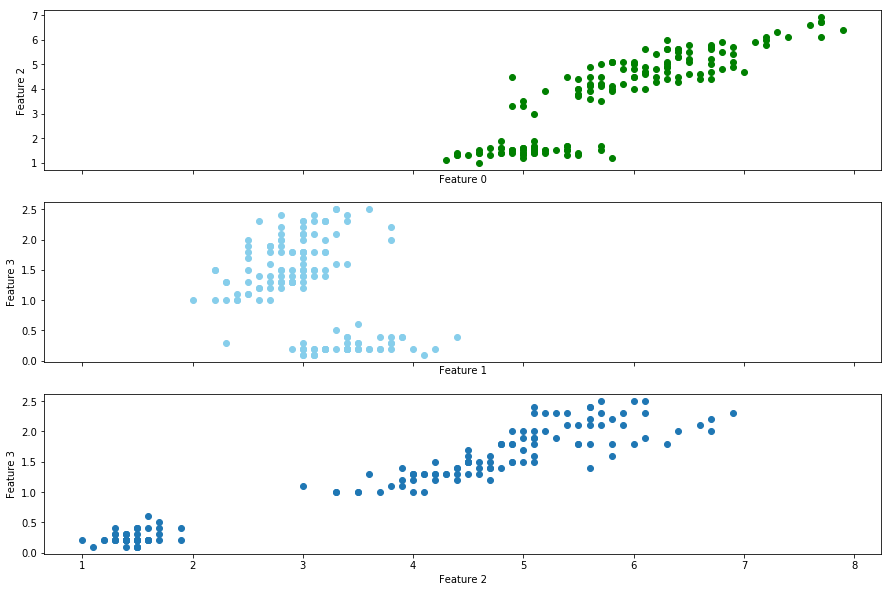

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10 #To give a bigger plot

x1=df.loc[:,0]
y1=df.loc[:,2]

x2=df.loc[:,1]
y2=df.loc[:,3]

x3=df.loc[:,2]
y3=df.loc[:,3]

fig, axs = plt.subplots(3, 1, sharex='all')

# Plot each graph, and manually set the y tick values
axs[0].plot(x1, y1, 'o', color='g')
axs[0].set_ylabel('Feature 2')
axs[0].set_xlabel('Feature 0')

axs[1].plot(x2, y2, 'o',color='skyblue')
axs[1].set_ylabel('Feature 3')
axs[1].set_xlabel('Feature 1')

axs[2].plot(x3, y3,'o')
axs[2].set_ylabel('Feature 3')
axs[2].set_xlabel('Feature 2')

plt.show()

## Part 1
Implement the logistic regression model that discussed in the class
(with and without regularization). Use Gradient descent algorithm
for updating the parameters. Plot the results.

First, we are going to create the dataset that we are going to use
in this part. It will generated using the features number 0 and 2 with
the objective of predicting the output class.


In [16]:
def generate_data_with_features(data: pd.DataFrame, features: List[int], elements: int = None,
                                normalise: bool = False, test_elements: int = 0) -> \
        Tuple[Tuple[pd.DataFrame, pd.DataFrame], Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Method to obtain a dataset with the features and the size desired. This
    method return the data and the class that belongs to it. If test data is desired
    the method will return two different tuples, both containing a dataframe with the
    features and other with the class.

    To retrieve correctly the data of the method, the following examples should be
    followed:

    ```
    train, test = generate_data_with_features(...)
    ```

    or

    ```
    train_x, train_y, test_x, test_y = generate_data_with_features(...)
    ```

    Normalisation are made in column by column style, using only numeric columns.

    :param data: dataframe with the original data
    :param features: list with the column name of the features
    :param elements: number of elements, when not specified the full dataset will be used
    :param normalise: flag to normalise the data
    :param test_elements: int with the number of rows to be used as test
    :return: dataframes with the new data with the desired characteristics
    """
    if elements is None:  # take full data
        elements = len(data)

    train_x = data[features][:elements]
    train_y = data.iloc[:, -1][:elements]

    if normalise:
        for i in features:
            column = train_x[i].values.reshape(-1, 1)
            if column.dtype == np.float64 or column.dtype == np.int64:
                min_max_scaler = preprocessing.MinMaxScaler()
                scaled_column = min_max_scaler.fit_transform(column)
                train_x[i] = scaled_column.reshape(-1)

    le = preprocessing.LabelEncoder()  # transform the class to 0 and 1
    train_y = le.fit_transform(train_y)

    test_x = None
    test_y = None
    if test_elements != 0 and elements > test_elements:
        train_elements = elements - test_elements
        test_x = train_x[train_elements:]
        train_x = train_x[:train_elements]
        test_y = train_y[train_elements:]
        train_y = train_y[:train_elements]

    return (pd.DataFrame(train_x).T, pd.DataFrame(train_y).T), (pd.DataFrame(test_x).T, pd.DataFrame(test_y).T)

This method generates the required data to train the logistic regression model, returning
a dataframe with the features of the data and other with the class. Therefore, for the
same row the first dataset will have the values for a given instance and the second the
class.

In [17]:
train, test = generate_data_with_features(df, elements=100, features=[0, 2], normalise=True)

The following methods will be used to train the logistic regression model, using the
data previously generated.

In [20]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    The sigmoid function that applies to the result of the product of the weight and the activation of the
    neurons plus the biases, known as weighted input.
    z = w_l*a_l+b

    :param z: weighted input.
    :return: activation of the next layer of the network
    """
    return 1.0 / (1 + np.exp(-z))


def forward_pass(x: np.ndarray, weights: np.ndarray, bias: float) -> np.ndarray:
    """
    Method that calculates the activation of the sigmoid function
    from a given input, weights and biases.

    :param x: input data
    :param weights: tuple with the weights
    :param bias: value of the biases
    :return: activation of the model for each row of the input
    """
    weighted_input = np.dot(weights, x) + bias
    return sigmoid(weighted_input)


def calculate_derivatives(x: np.ndarray, y: np.ndarray, weights: np.ndarray, bias: float,
                          regularization_term: float = 0) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Method that propagates the input and calculates the cost and the derivative of the
    weights and the biases.

    :param x: input data
    :param y: output data
    :param weights: weights of the model
    :param bias: bias of the model
    :param regularization_term: value of lambda
    :return: tuple with the cost, the derivative of the weights and bias
    """
    n_samples = y.shape[1]
    activation = forward_pass(x, weights, bias)
    cost = np.mean(-y * np.log(activation) - (1 - y) * np.log(1 - activation))
    cost = cost + regularization_term / (2 * n_samples) * np.dot(weights.T, weights)  # lambda/2m*sum(theta^2)
    dz = -(y - activation) / n_samples
    dw = np.dot(dz, x.T).squeeze()
    db = np.sum(dz)
    return cost, dw, db


def train_model(train_data: Tuple[pd.DataFrame, pd.DataFrame], epochs: int, learning_rate: float = 0.5,
                regularization_term: float = 0) -> Tuple[np.ndarray, float, np.ndarray]:
    """
    Method to train the model

    :param train_data: training data, with the features and the outputs
    :param epochs: number of epochs to train the model
    :param learning_rate: value of the learning rate, alpha
    :param regularization_term: value of the regularization term, lambda
    :return: weights and bias of the trained model. List of the costs during training
    """
    x, y = train_data  # extract the data and the classes
    n_samples = y.shape[1]
    costs = list()
    bias = 1
    weights = np.random.uniform(low=-0.7, high=0.7, size=x.shape[0])
    for epoch in range(epochs):
        cost, dw, db = calculate_derivatives(x=x.to_numpy(), y=y.to_numpy(), weights=weights,
                                             bias=bias, regularization_term=regularization_term)
        if epoch % 500 == 0:
            print('The cost in epoch {0} was {1}'.format(epoch, cost))
        costs.append(cost)
        weights -= learning_rate * (dw + regularization_term / n_samples * weights)
        bias -= learning_rate * (db + regularization_term / n_samples * bias)
    print('Finished training, trained during {0}'.format(epochs))
    return weights, bias, np.array(costs)

For getting outputs and testing we implement the following methods

In [ ]:
def predict(x: np.ndarray, weights: np.ndarray, bias: float) -> np.ndarray:
    """
    Method that outputs the system response
    of a given input, weights and biases.

    :param x: input data
    :param weights: tuple with the weights
    :param bias: value of the biases
    :return: output of the system for each row of the input
    """
    activation = forward_pass(x, weights, bias)
    return 1 * (activation > 0.5)


def get_prob_and_cost(x: np.ndarray, y: np.ndarray, weights: np.ndarray,
                      bias: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Method that outputs the system response
    of a given input, weights and biases.

    :param x: input data
    :param weights: tuple with the weights
    :param bias: value of the biases
    :return: output of the system
    """
    activation: np.ndarray = forward_pass(x, weights, bias)
    cost: np.ndarray = -y * np.log(activation) - (1 - y) * np.log(1 - activation)
    return activation, cost.squeeze()


def test_model(test_data: Tuple[pd.DataFrame, pd.DataFrame], weights: np.ndarray, bias: float):
    """
    Method that calculates the percentage of error given a test dataset.

    :param test_data: test data, with the features and the outputs
    :param weights: weights of the trained model
    :param bias: bias of the trained model
    :return:
    """
    x, y = test_data
    predicted_y = predict(x.to_numpy(), weights, bias)
    diff_pred_real = abs(predicted_y - y.to_numpy().squeeze())
    percentage_error = np.count_nonzero(diff_pred_real == 1) / len(diff_pred_real)
    return percentage_error

The main method will be `train_model` that will use the training data and will require
the number of training epochs, the learning rate and the regularization term. It will
return the weights and bias for the model trained along with an array with the cost
during training.

The method `predict` can be used to calculate the output for a given input, weight and
bias.  

In [21]:
weights, bias, costs = train_model(train, epochs=2000, learning_rate=0.2, regularization_term=0.0)

The cost in epoch 0 was 0.8436789313734963
The cost in epoch 500 was 0.13182001169946952
The cost in epoch 1000 was 0.07475799666862347
The cost in epoch 1500 was 0.05370045610931931
Finished training, trained during 2000


Now, we try diferent values of learning rates for Gradient Descent (alphas) and regularization terms (lambdas), plotting the results of the cost for features 0 and 2.  

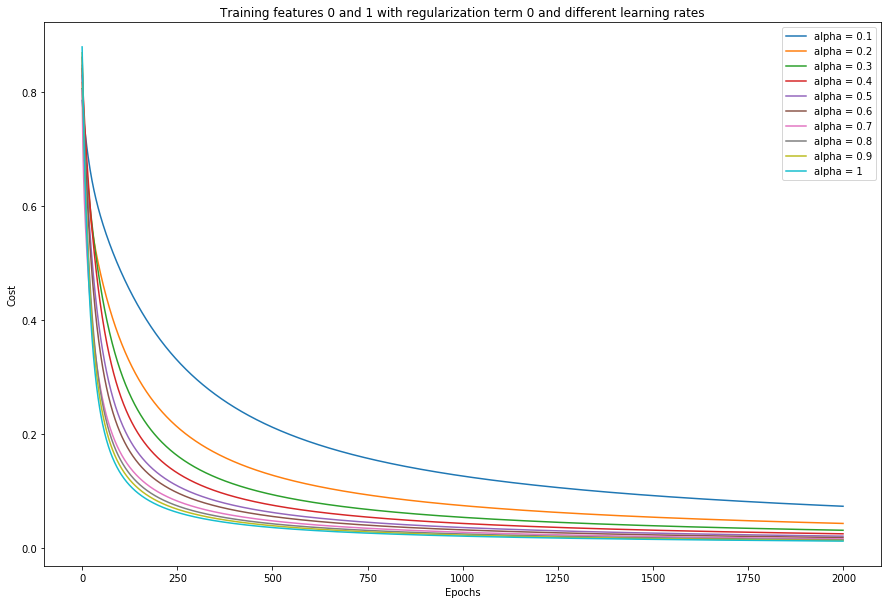

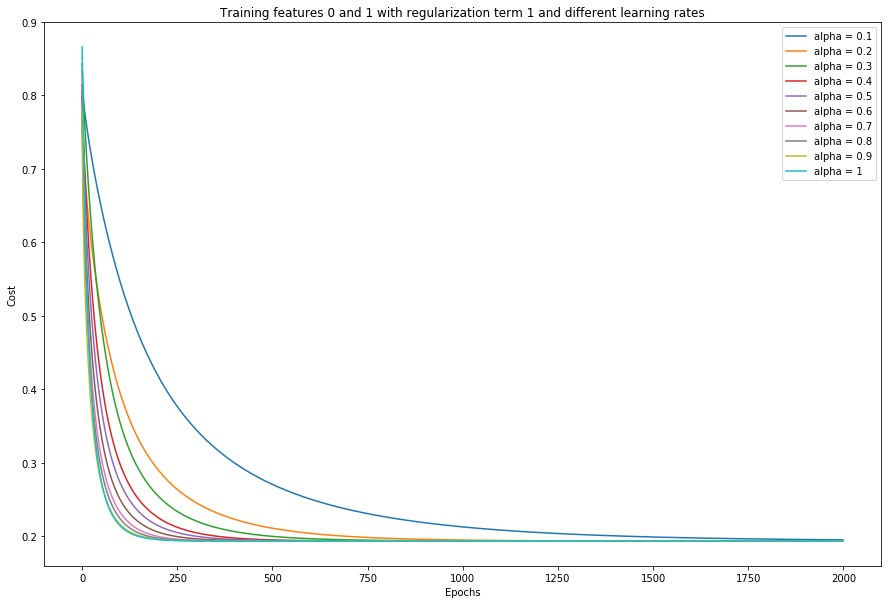

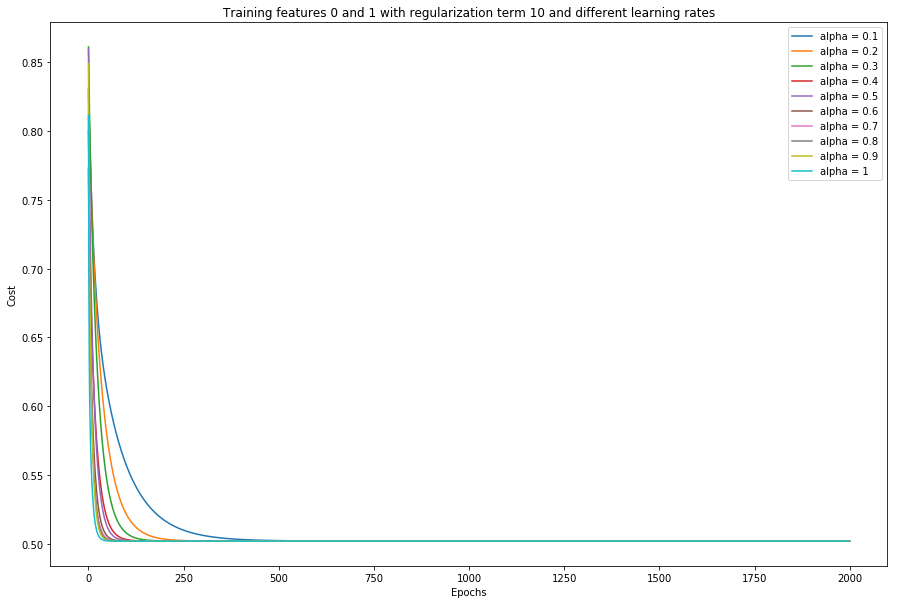

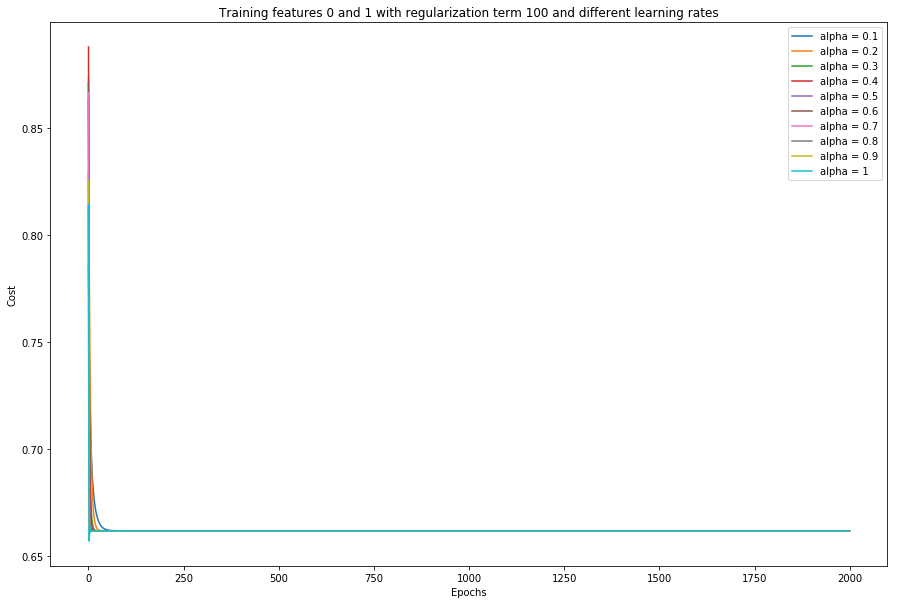

In [9]:
alphas=[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1] #Learning rate
lambdas=[0, 1, 10, 100] #Regularization term

    
for l in lambdas:
    for i in range(0,10):
        
        weights, bias, costs = train_model(train, epochs=int(2000), learning_rate=alphas[i], regularization_term=l)
        p=plt.plot(costs, label='alpha = '+str(alphas[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
    plt.title('Training features 0 and 1 with regularization term '+str(l)+' and different learning rates')
    plt.legend()
    plt.show()

The bigger the learning rate, the faster it converges to the cost. However, if we add the regularization term, then our cost increases to avoid the overfitting of our model and the convergence is much faster. In the following, we compare our results for different features.

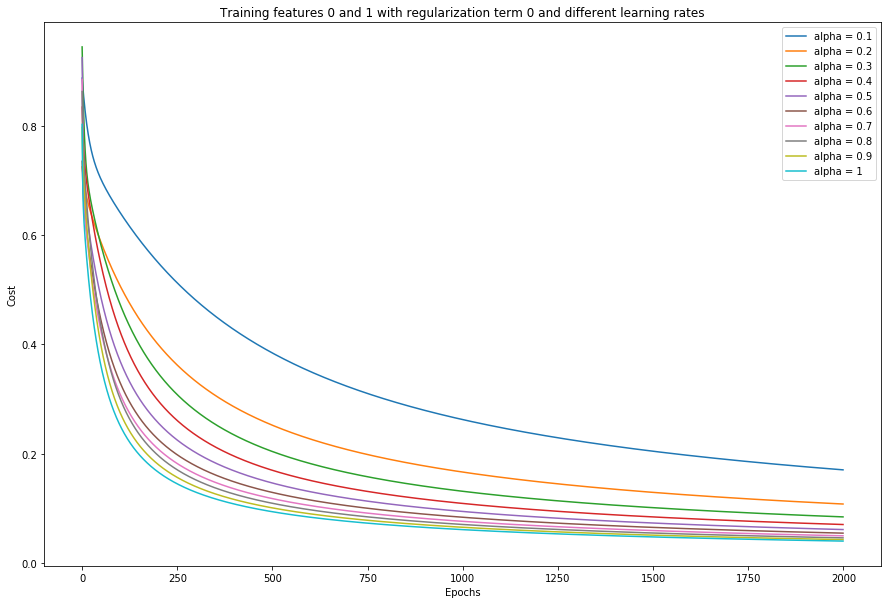

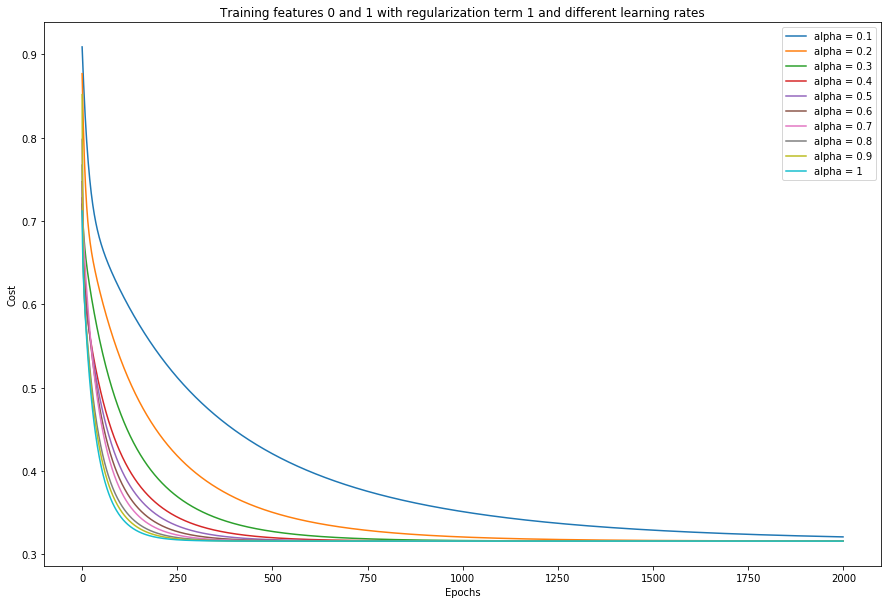

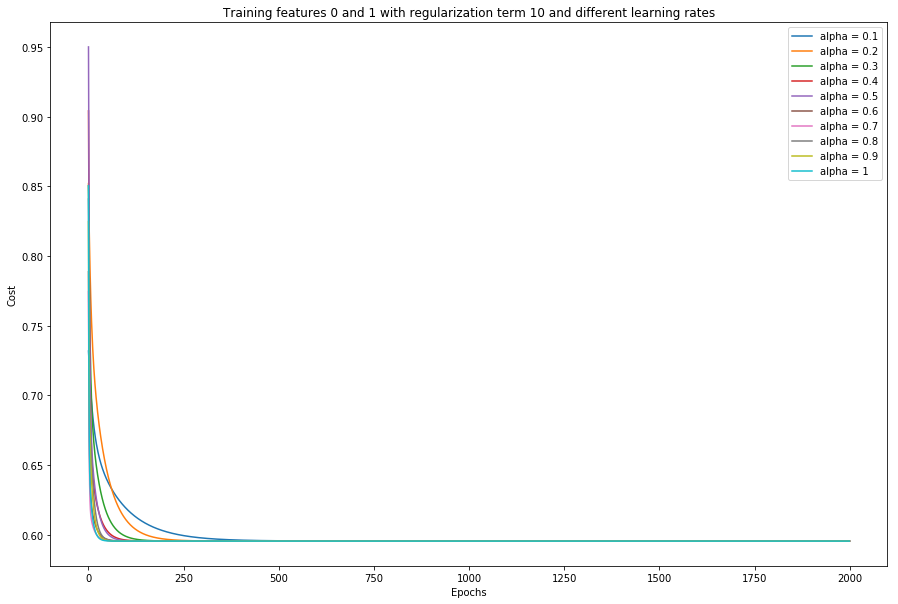

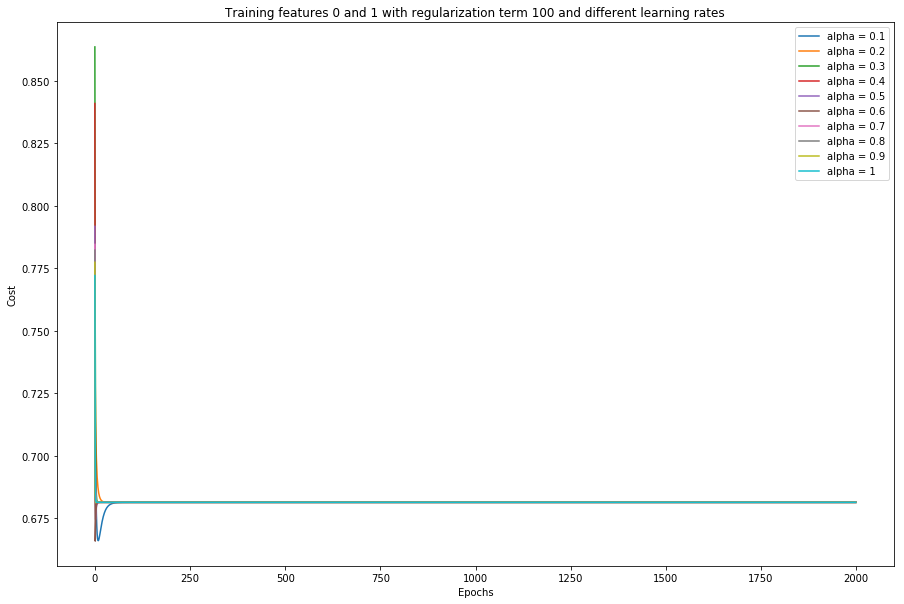

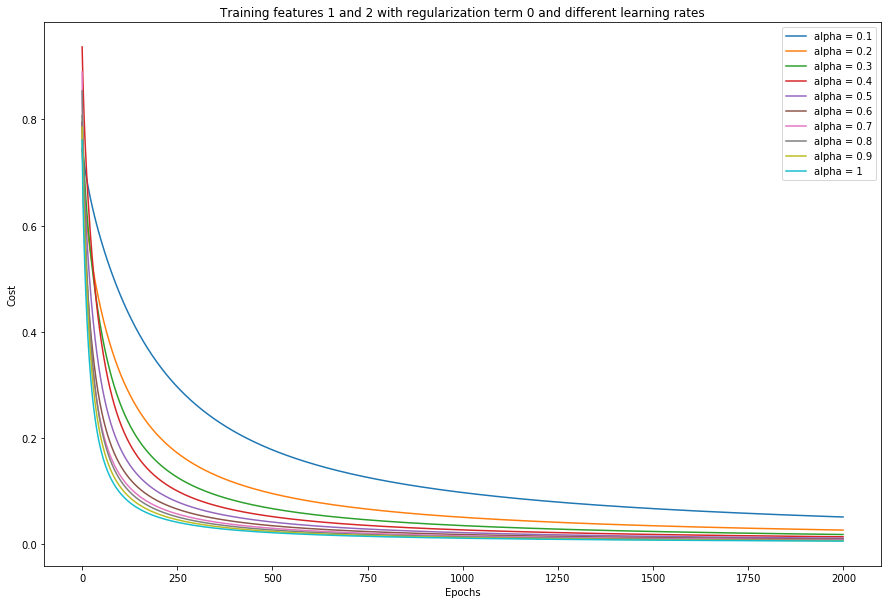

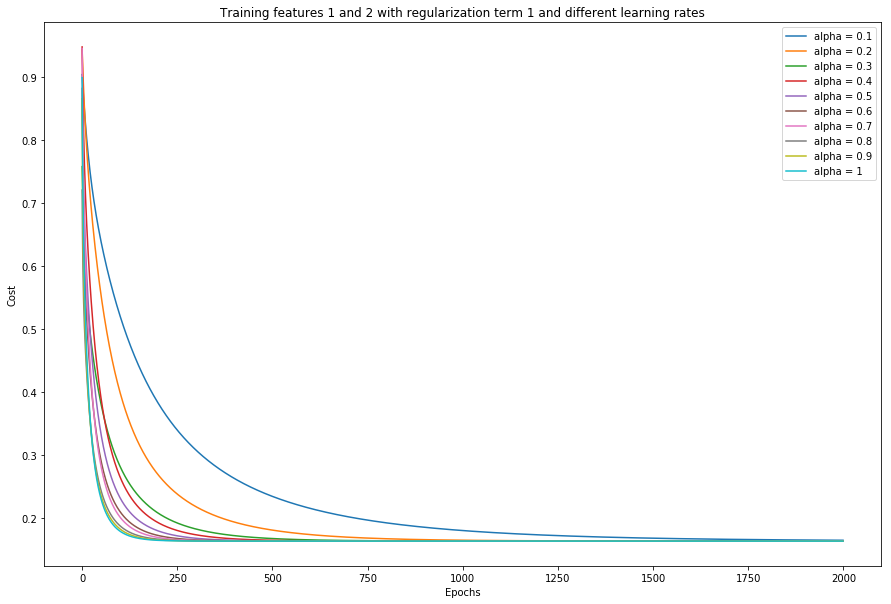

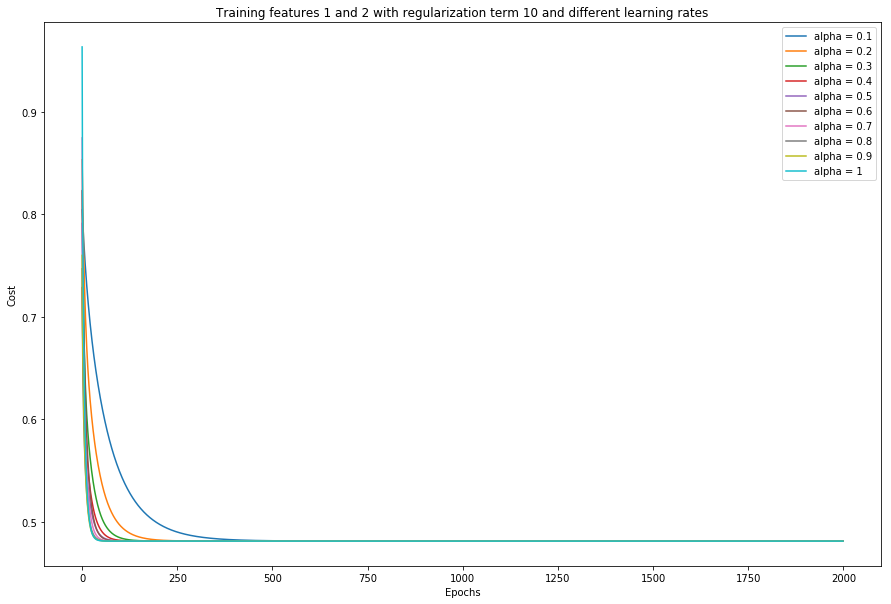

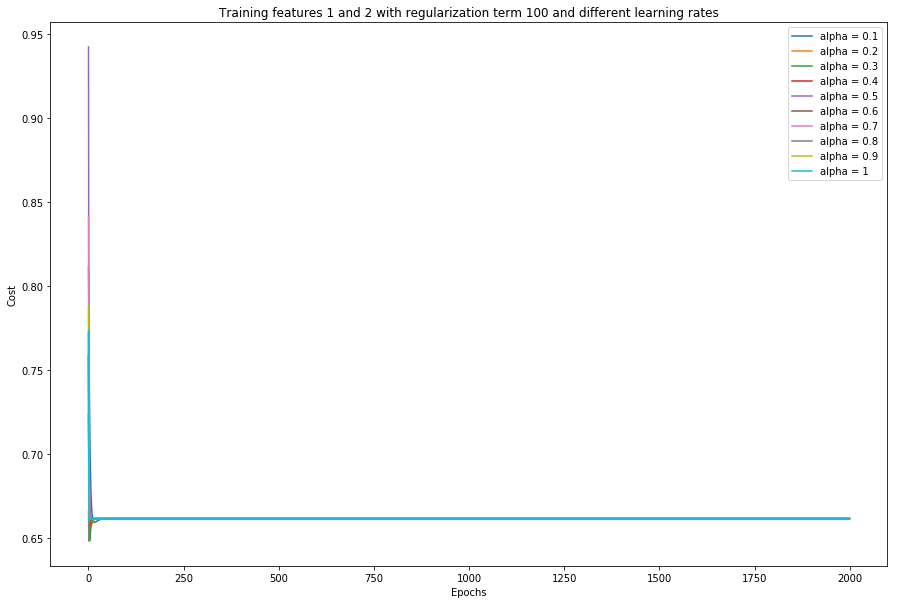

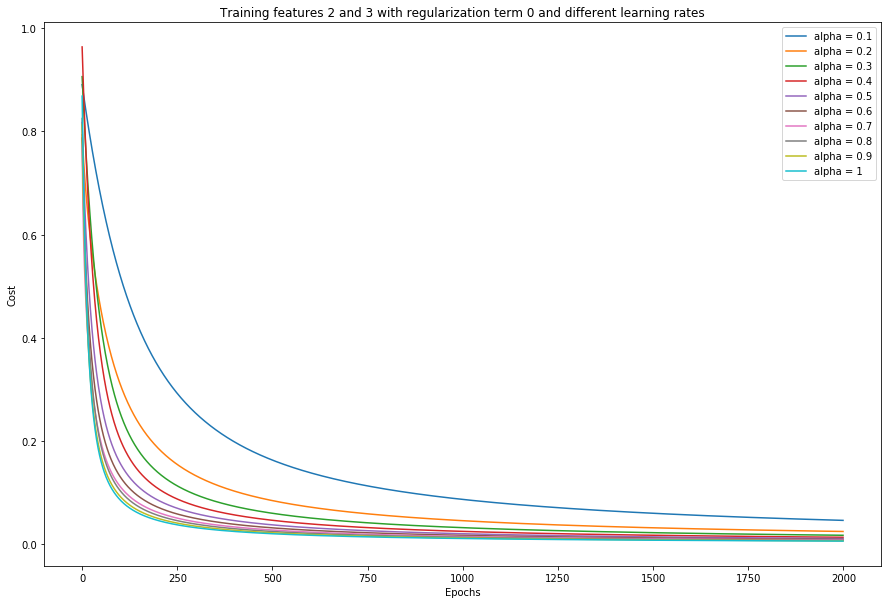

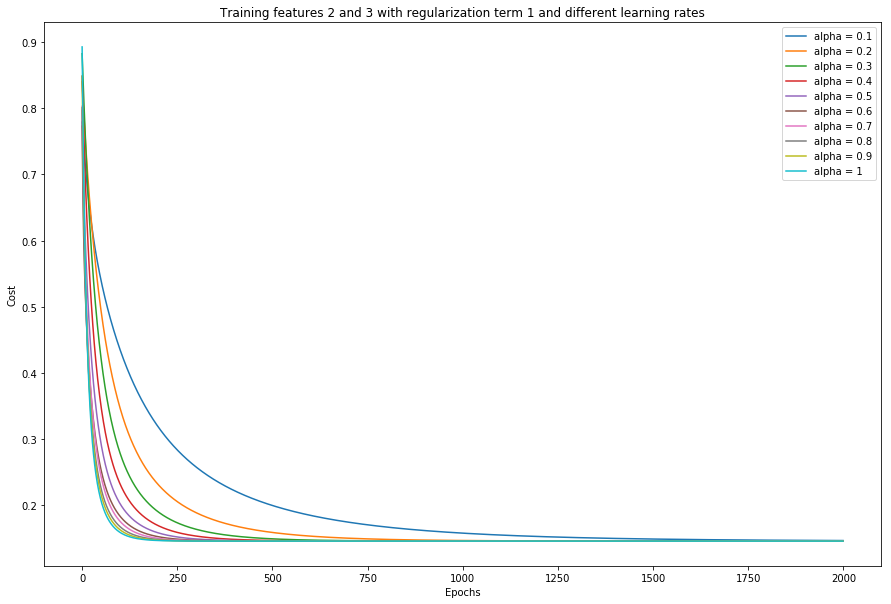

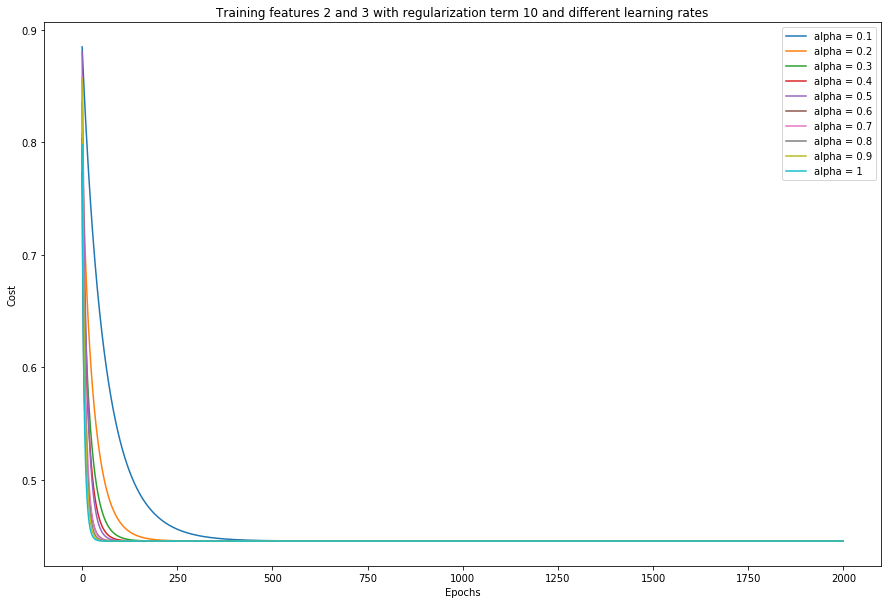

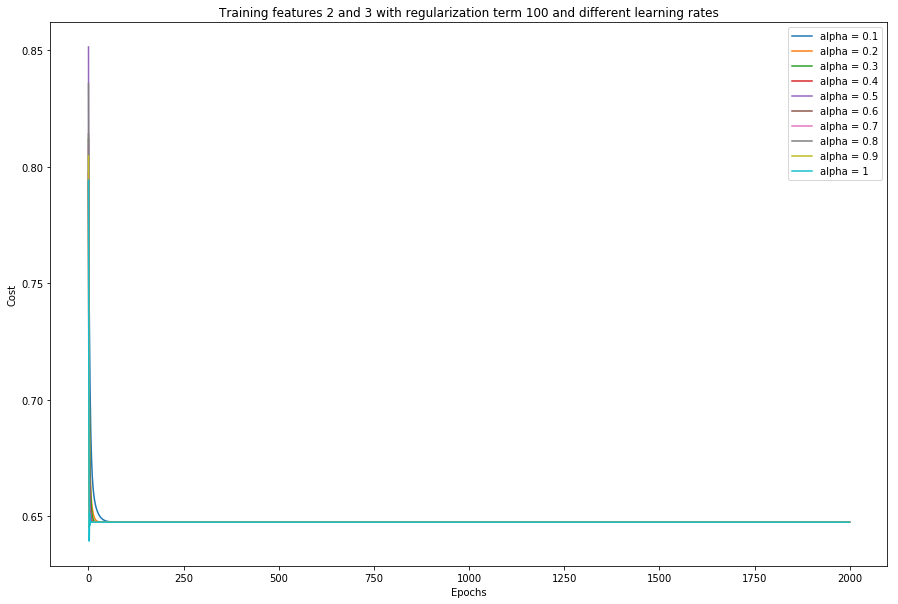

In [10]:
alphas=[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1] #Learning rate
lambdas=[0, 1, 10, 100] #Regularization term

for f1 in range(0,3): #1st feature
    f2=f1+1 #2nd feature
    train_data = generate_data_with_features(df, [f1, f2], normalise=True)
    for l in lambdas:
        for i in range(0,10):

            weights, bias, costs = train_model(train_data, epochs=int(2000), learning_rate=alphas[i], regularization_term=l)
            p=plt.plot(costs, label='alpha = '+str(alphas[i]))
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
        plt.title('Training features '+str(f1)+' and '+str(f2)+' with regularization term '+str(l)+' and different learning rates')
        plt.legend()
        plt.show()

As we can see here, the results of different features are quite similar since the data set seems to tend to overfitting. On one hand, for small regularization the model converges slowly and gets a small cost. On the other hand, for big regularization the model converges really fast but we get bigger cost. The bigger the learning rate, the faster it converges. Now, we provide a code to choose the features and the parameters in order to get a plot of the cost.

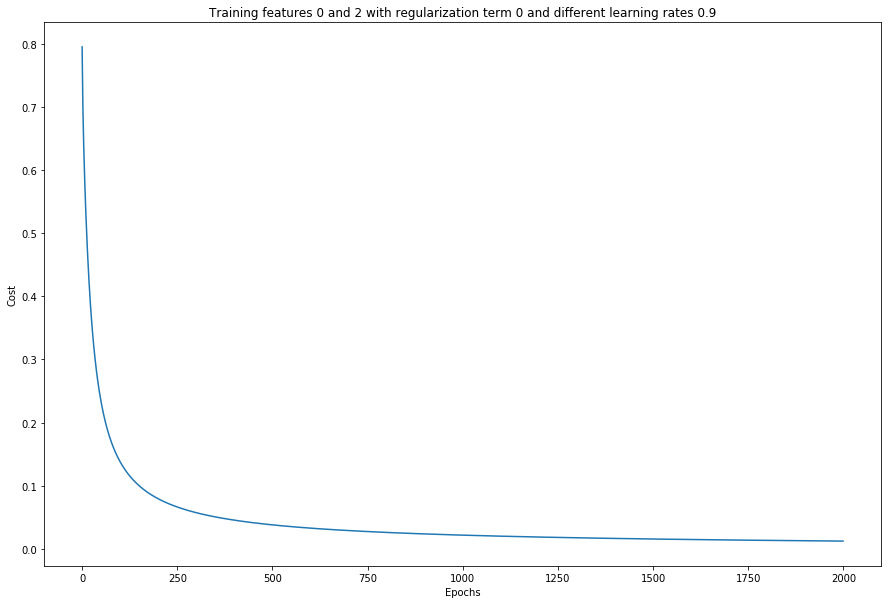

In [11]:
#Define the parameters
alphas=0.9
lambdas=0
epochs=2000

#Define features
f1=0
f2=2

train_data = generate_data_with_features(df, [f1, f2], normalise=True)
weights, bias, costs = train_model(train_data, epochs=int(epochs), learning_rate=alphas, regularization_term=lambdas)

plt.plot(costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training features '+str(f1)+' and '+str(f2)+' with regularization term '+str(lambdas)+' and different learning rates '+str(alphas))
plt.savefig('figure with features '+str(f1)+str(f2)+'and lambda'+str(lambdas))
plt.show()

## Part 2
In this part we use 80% of the Monk2 data set for training and 20% of the data set for testing. Firstly, we converted monk2.mat to .csv using a Matlab tool. 

In [12]:
monk = pd.DataFrame(loadmat('./data/monk2.mat')['monk2'])
monk.head()

,0,1,2,3,4,5,6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,2,1
2,1,1,1,1,2,2,1
3,1,1,1,1,3,1,1
4,1,1,1,1,3,2,1


In [ ]:
train_data_monk = generate_data_with_features(monk, [0, 1], normalise=True)

In [19]:
weights, bias, costs = train_model(train_data_monk, epochs=int(2000), learning_rate=0.9, regularization_term=0)

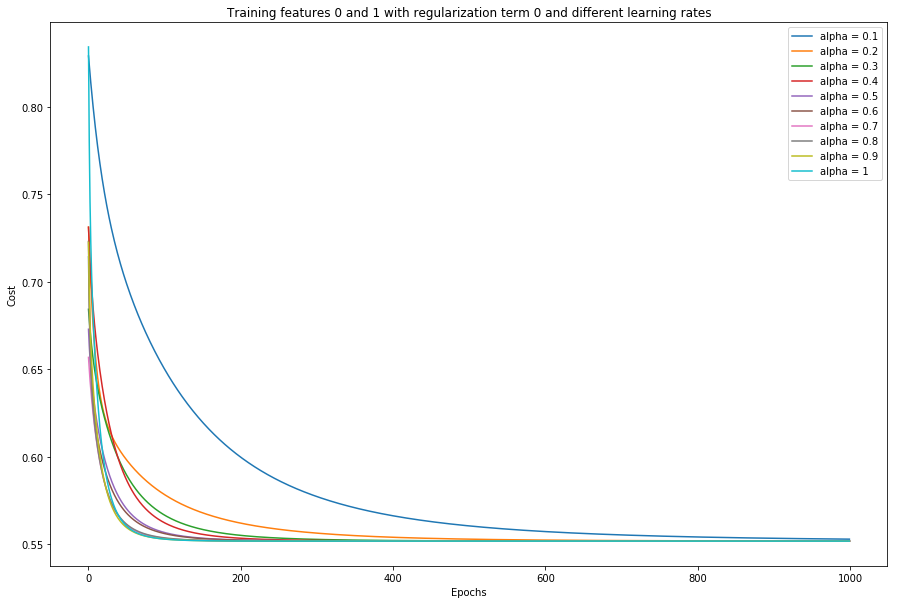

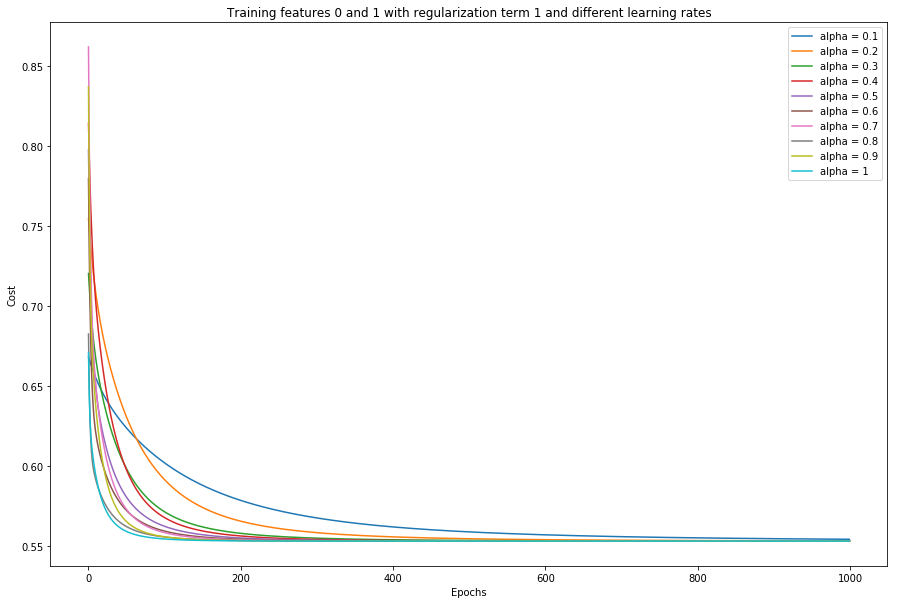

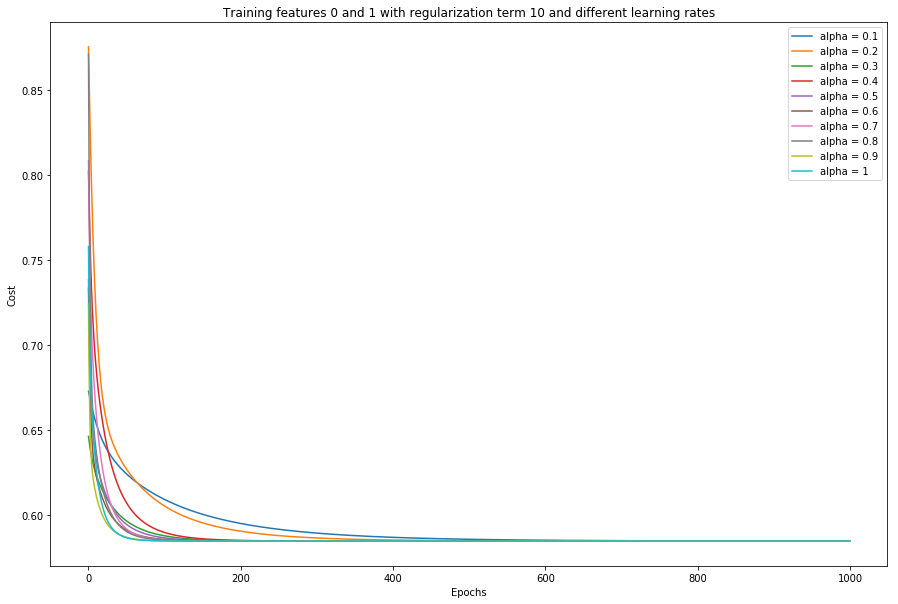

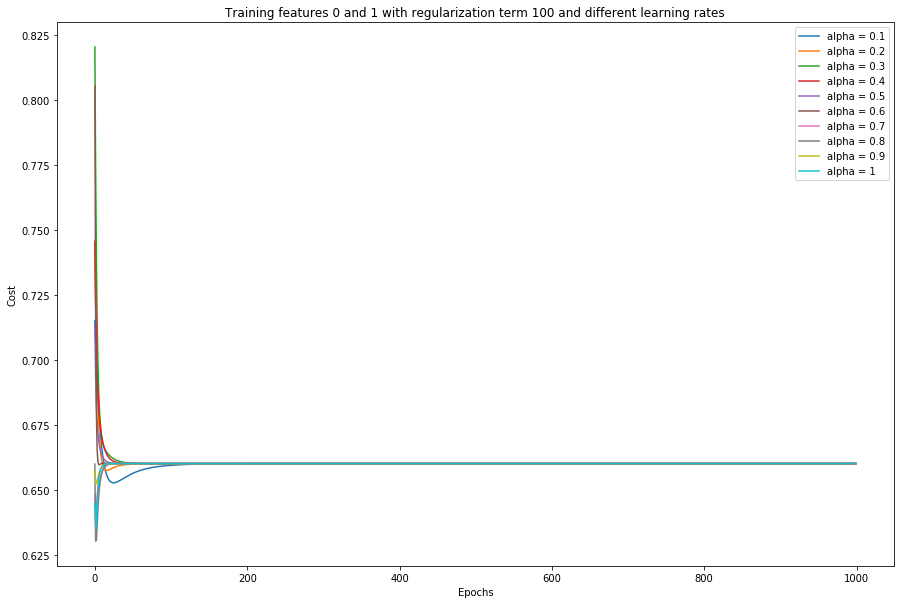

In [21]:
alphas=[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1] #Learning rate
lambdas=[0, 1, 10, 100] #Regularization term

    
for l in lambdas:
    for i in range(0,10):
        
        weights, bias, costs = train_model(train_data_monk, epochs=int(1000), learning_rate=alphas[i], regularization_term=l)
        p=plt.plot(costs, label='alpha = '+str(alphas[i]))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
    plt.title('Training features 0 and 1 with regularization term '+str(l)+' and different learning rates')
    plt.legend()
    plt.show()